<a href="https://colab.research.google.com/github/robertcorado13/Mr.-Null-Files/blob/master/corado_robert_set4_prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))

60000 <class 'torch.Tensor'> <class 'int'>


We can convert images to numpy arrays and plot them with matplotlib:

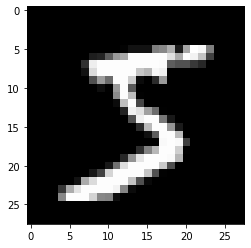

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Network Definition
Let's instantiate a model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 10)
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=20, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=20, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 

We now write our backpropagation loop, training for 10 epochs.

In [ ]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.4313
Train Epoch: 2  Loss: 0.6605
Train Epoch: 3  Loss: 0.9037
Train Epoch: 4  Loss: 0.4305
Train Epoch: 5  Loss: 0.8738
Train Epoch: 6  Loss: 0.4491
Train Epoch: 7  Loss: 0.8815
Train Epoch: 8  Loss: 0.6077
Train Epoch: 9  Loss: 0.8083
Train Epoch: 10  Loss: 0.7267


## Testing
We can perform forward passes through the network without saving gradients.

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0081, Accuracy: 9246/10000 (92.4600)


## Training on GPU
Google provides the use of free GPU for Colab notebooks, which can accelerate your training process.

First, follow Edit > Notebook settings or Runtime>Change runtime type and select **GPU** as Hardware accelerator.

Then run the following code

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# When you are on a CUDA machine, this should print a CUDA device:
print(device)

cpu



Move model to the right device. Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [ ]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=20, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=20, out_features=10, bias=True)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [ ]:
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.5359
Train Epoch: 2  Loss: 0.9239
Train Epoch: 3  Loss: 0.7338
Train Epoch: 4  Loss: 0.4187
Train Epoch: 5  Loss: 0.6604
Train Epoch: 6  Loss: 0.5272
Train Epoch: 7  Loss: 1.3692
Train Epoch: 8  Loss: 0.5914
Train Epoch: 9  Loss: 0.4364
Train Epoch: 10  Loss: 0.7297


In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0080, Accuracy: 9274/10000 (92.7400)


Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

# **Problem 2B**

In [ ]:
# Create a new model with 100 hidden units.
modelB = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
)
print(modelB)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


# Training

In [ ]:
# Choose an optimizer and a loss function.
optimizerB = torch.optim.RMSprop(modelB.parameters(), lr=1e-3)
loss_fnB = nn.CrossEntropyLoss()

# Some layers, such as Dropout, behave differently during training
modelB.train()
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizerB.zero_grad()

        # Forward pass
        output = modelB(data)

        # Calculate loss
        loss = loss_fnB(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizerB.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 1.5746
Train Epoch: 2  Loss: 1.4996
Train Epoch: 3  Loss: 1.4805
Train Epoch: 4  Loss: 1.5174
Train Epoch: 5  Loss: 1.5247
Train Epoch: 6  Loss: 1.4640
Train Epoch: 7  Loss: 1.4626
Train Epoch: 8  Loss: 1.4788
Train Epoch: 9  Loss: 1.4764
Train Epoch: 10  Loss: 1.4623
Train Epoch: 11  Loss: 1.4612
Train Epoch: 12  Loss: 1.4612
Train Epoch: 13  Loss: 1.4719
Train Epoch: 14  Loss: 1.4949
Train Epoch: 15  Loss: 1.4612
Train Epoch: 16  Loss: 1.4952
Train Epoch: 17  Loss: 1.4925
Train Epoch: 18  Loss: 1.4615
Train Epoch: 19  Loss: 1.4612
Train Epoch: 20  Loss: 1.4945


# Testing

In [ ]:
# Putting layers like Dropout into evaluation mode
modelB.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = modelB(data)
        test_loss += loss_fnB(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       correct / len(test_loader.dataset)))

Test set: Average loss: 0.0465, Accuracy: 9744/10000 (0.9744)


# Problem 2C

In [ ]:
# Create a new model with 200 hidden units.
modelC = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 150),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(150, 50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(50, 10),
)
print(modelC)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=150, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=150, out_features=50, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=50, out_features=10, bias=True)
)


# Training

In [ ]:
# Choose an optimizer and a loss function.
optimizerC = torch.optim.RMSprop(modelC.parameters(), lr=1e-3)
loss_fnC = nn.CrossEntropyLoss()

# Some layers, such as Dropout, behave differently during training
modelC.train()
for epoch in range(11):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizerC.zero_grad()

        # Forward pass
        output = modelC(data)

        # Calculate loss
        loss = loss_fnC(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizerC.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.1607
Train Epoch: 2  Loss: 0.2965
Train Epoch: 3  Loss: 0.0209
Train Epoch: 4  Loss: 0.0547
Train Epoch: 5  Loss: 0.0581
Train Epoch: 6  Loss: 0.5460
Train Epoch: 7  Loss: 0.0292
Train Epoch: 8  Loss: 0.0811
Train Epoch: 9  Loss: 0.1409
Train Epoch: 10  Loss: 0.0051
Train Epoch: 11  Loss: 0.1640


# Testing

In [ ]:
# Putting layers like Dropout into evaluation mode
modelC.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = modelC(data)
        test_loss += loss_fnC(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       correct / len(test_loader.dataset)))

Test set: Average loss: 0.0022, Accuracy: 9804/10000 (0.9804)


# Problem 2D

In [ ]:
# Create a new model with 1000 hidden units.
modelD = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 700),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(700, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
)
print(modelD)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=700, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=700, out_features=200, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=200, out_features=100, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=100, out_features=10, bias=True)
  (11): Softmax(dim=1)
)


# Training

In [ ]:
# Choose an optimizer and a loss function.
optimizerD = torch.optim.RMSprop(modelD.parameters(), lr=1e-3)
loss_fnD = nn.CrossEntropyLoss()

# Some layers, such as Dropout, behave differently during training
modelD.train()
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizerD.zero_grad()

        # Forward pass
        output = modelD(data)

        # Calculate loss
        loss = loss_fnD(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizerD.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 1.4933
Train Epoch: 2  Loss: 1.4702
Train Epoch: 3  Loss: 1.5371
Train Epoch: 4  Loss: 1.4920
Train Epoch: 5  Loss: 1.4924
Train Epoch: 6  Loss: 1.4945
Train Epoch: 7  Loss: 1.4924
Train Epoch: 8  Loss: 1.4924
Train Epoch: 9  Loss: 1.4612
Train Epoch: 10  Loss: 1.5237


# Testing

In [ ]:
# Putting layers like Dropout into evaluation mode
modelD.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = modelD(data)
        test_loss += loss_fnD(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       correct / len(test_loader.dataset)))

Test set: Average loss: 0.0473, Accuracy: 9497/10000 (0.9497)
